# Image classification with Keras TensorFlow

Can a computer tell the difference between a chest X-ray and a microscope photo?  Let's find out!

![](other_assets/screenshots/CNNdiagram.jpg)

(Try playing with a neural network in the browser [here](http://bit.ly/2shH9YT) first!)

In [1]:
import pandas as pd
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from IPython.display import Image as Image_
from IPython.display import display
import datetime as dt
from PIL import Image
from io import BytesIO
import random
import time

## Collect image URLs

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We want 5,500 images from each class to split into train/test/validation sets.  We'll use the function below to make sure that:

* the path to the corresponding .png file exists at a given URL;

* the path has a valid request (i.e., link contains an image).

In [2]:
def get_image_size(url):
    data = requests.get(url).content
    im = Image.open(BytesIO(data))
    return im.size

In [3]:
## main part of URL
base_url = 'https://openi.nlm.nih.gov'

In [4]:
## components for class-specific queries
chestxray = ['coll=iu', 'chest']
microscopy = ['it=mc', 'micro']

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The assumption we make in the following loop is that URLs for 5,500 of each class we've chosen actually exist on the MedPix server.  Their instructions for query structure are [here](https://openi.nlm.nih.gov/services.php).

In [5]:
# start = dt.datetime.now()
# print(start)

# big_list = []
# for which in [chestxray, microscopy]:
#     lil_count = 0 ## counts valid hrefs to ensure 5500 of each class
#     idx = 1 ## image queries start at 1, not 0
#     lil_list = []
#     while lil_count < 5501:
#         url = ''.join([base_url, '/retrieve.php?{}&m={}&n={}'.format(which[0], idx, idx)])
#         try:
#             request = requests.get(url)
#             soup = BeautifulSoup(request.content, 'lxml')
#             try:
#                 for child in soup.findChildren('p'):
#                     if 'imgLarge' in str(child):
#                         childlet = str(child).split('\"imgLarge\": \"')[1].split('\",')[0]
#                         href = ''.join([base_url, childlet])
#                         get_image_size(href)
#                         lil_list.append(childlet)
#                         lil_count += 1
#             except:
#                 print('\nNo .png:', which[1], url)
#         except:
#             print('\n{}: '.format(str(request)), which[1], url)
#         idx += 1
#         if lil_count%100 == 0:
#             print('.', end = '')

#     which_df = pd.DataFrame(lil_list, columns = [which[1]])
#     which_df.to_csv('other_assets/urls_{}.csv'.format(which[1]), index = False)
#     if which == chestxray:
#         print('\n--round one finished--\n')

# print('\n\ndone in: ', dt.datetime.now() - start)

# del which_df

#### The cell above gave the following output:

![output](other_assets/screenshots/scrape_print.png)

#### Check the .png paths the loop spat out ("imgLarge"):

https://openi.nlm.nih.gov/retrieve.php?it=mc&m=2971&n=2971

![badlink_1](other_assets/screenshots/badlink_1.png)

https://openi.nlm.nih.gov/retrieve.php?it=mc&m=2972&n=2972

![badlink_2](other_assets/screenshots/badlink_2.png)

#### The links contain no image:

https://medpix.nlm.nih.gov/imgs/512/151/4308495/PMC4308495_pnga-60-192-g001.png

https://medpix.nlm.nih.gov/imgs/137/151/4308495/PMC4308495_pnga-60-192-g003.png

![](other_assets/screenshots/pagenotfound.png)

## Do train/test/validation/singleton splits

This cell loads output of previous code cell (so you don't have to keep running it!) and concatenates individual data frames:

In [6]:
urls_micro = pd.read_csv('other_assets/urls_micro.csv')
urls_chest = pd.read_csv('other_assets/urls_chest.csv')

urls = pd.concat([urls_micro, urls_chest], axis = 1)

del urls_micro
del urls_chest

urls.head()

,micro,chest
0,/imgs/512/230/1032/MPX1032_synpic23886.png,/imgs/512/10/10/CXR10_IM-0002-1001.png
1,/imgs/512/230/1032/MPX1032_synpic23887.png,/imgs/512/10/10/CXR10_IM-0002-2001.png
2,/imgs/512/230/1032/MPX1032_synpic23888.png,/imgs/512/1/1/CXR1_1_IM-0001-3001.png
3,/imgs/512/227/1029/MPX1029_synpic17373.png,/imgs/512/1/1/CXR1_1_IM-0001-4001.png
4,/imgs/512/227/1029/MPX1029_synpic17374.png,/imgs/512/199/1001/CXR1001_IM-0004-1001.png


In [7]:
## split off 0.1% for singleton testing
micro_big, micro_singleton = train_test_split(urls['micro'], random_state = 421, test_size = 0.001)
chest_big, chest_singleton = train_test_split(urls['chest'], random_state = 365, test_size = 0.001)

In [8]:
## of remainder, split off 10% for validation set
micro_lessbig, micro_valid = train_test_split(micro_big, random_state = 421, test_size = 0.1)
chest_lessbig, chest_valid = train_test_split(chest_big, random_state = 365, test_size = 0.1)

In [9]:
## of new remainder, split off 20% for test set (balance is training set)
micro_train, micro_test = train_test_split(micro_lessbig, random_state = 421, test_size = 0.2)
chest_train, chest_test = train_test_split(chest_lessbig, random_state = 365, test_size = 0.2)

In [10]:
del micro_big, micro_lessbig, chest_big, chest_lessbig, urls

## Download images to file for preprocessing

In [11]:
## make a dictionary so we can loop instead of one cell per
series_dict = {
    0 : [micro_train, 'micro', 'training'], 
    1 : [chest_train, 'chest', 'training'], 
    2 : [micro_test, 'micro', 'testing'], 
    3 : [chest_test, 'chest', 'testing'], 
    4 : [micro_valid, 'micro', 'validation'], 
    5 : [chest_valid, 'chest', 'validation'],
    6 : [micro_singleton, 'micro', 'singleton'],
    7 : [chest_singleton, 'chest', 'singleton']
                   }

In [12]:
## reset indeces first so we can loop over index
for i in range(len(series_dict.keys())):
    series_dict[i][0].reset_index(drop = True, inplace = True)
    print(len(series_dict[i][0]))

3956
3956
989
989
550
550
6
6


In [13]:
def images_to_file(lil_series, lil_name, set_):
    '''Get .png file from URL and download locally to appropriate folder'''
    start = dt.datetime.now()
    print(start)
    count = 0
    fail_count = 0
    for i in range(len(lil_series)):
        href = base_url+lil_series[i]
        if (set_ == 'validation') or (set_ == 'singleton'):
            which = 'other_'
        else:
            which = ''
        path_extension = '{}assets/{}_set/{}/{}_{}.png'.format(which, set_, lil_name, lil_name, i)
        try:
            with open(path_extension, 'wb') as f:
                f.write(urlopen(href).read())
        except:
            print('\nSKIPPED ({}): {}'.format(i, href), end = '\n')
            fail_count += 1
        if count%100 == 0:
            print('.', end = '')
        count += 1
    print('\n\ndone: ', dt.datetime.now() - start)
    print('\ntotal skipped: {}\n\n'.format(fail_count))
    return

In [14]:
## the loop does it all!
for i in range(len(series_dict.keys())):
    images_to_file(series_dict[i][0], series_dict[i][1], series_dict[i][2])

2018-02-06 04:23:35.504451
........................................

done:  0:05:45.546004

total skipped: 0


2018-02-06 04:29:21.051119
........................................

done:  0:05:02.252053

total skipped: 0


2018-02-06 04:34:23.304306
..........

done:  0:01:25.510264

total skipped: 0


2018-02-06 04:35:48.814931
..........

done:  0:01:23.780499

total skipped: 0


2018-02-06 04:37:12.596145
......

done:  0:00:48.295766

total skipped: 0


2018-02-06 04:38:00.892230
......

done:  0:00:39.856428

total skipped: 0


2018-02-06 04:38:40.749674
.

done:  0:00:00.497340

total skipped: 0


2018-02-06 04:38:41.247837
.

done:  0:00:00.436855

total skipped: 0




In [15]:
del series_dict

## Inspect

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Let's see what some of the images look like before the computer sees them!  Select two randomly from the first 550 of each folder:

MICRO
from training set:


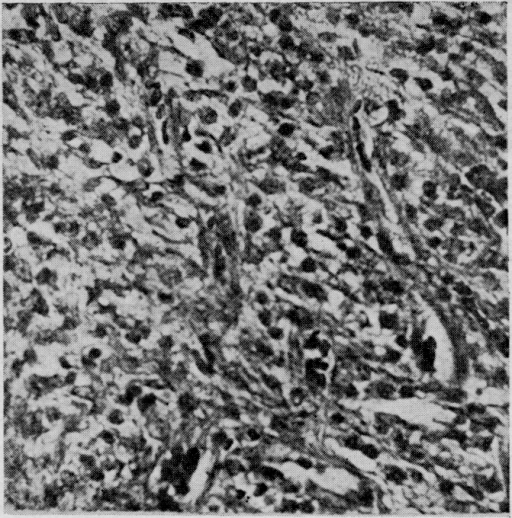

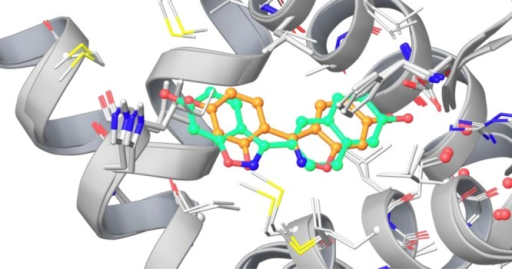

from testing set:


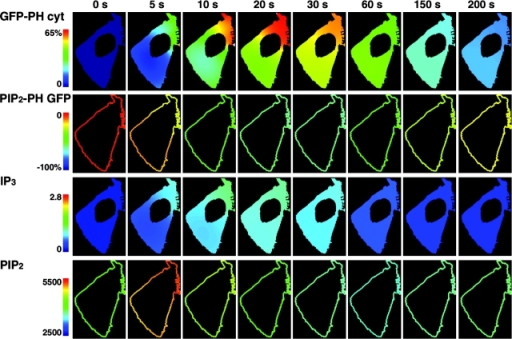

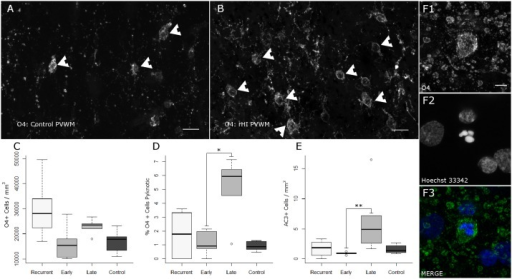

from validation set:


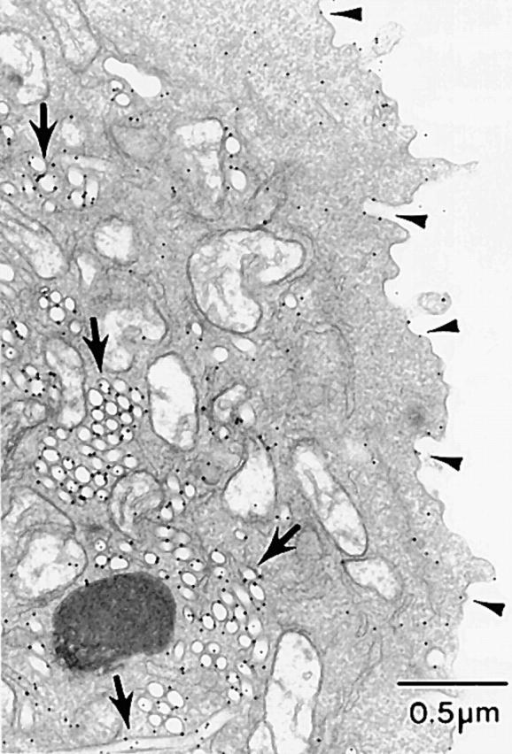

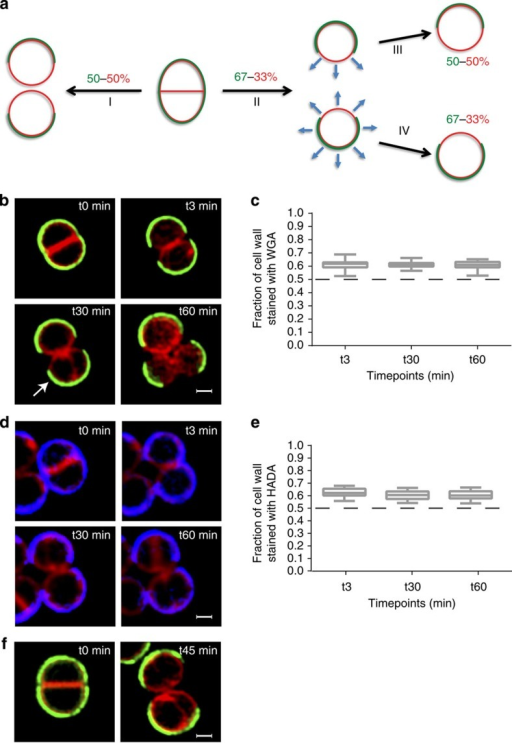

CHEST
from training set:


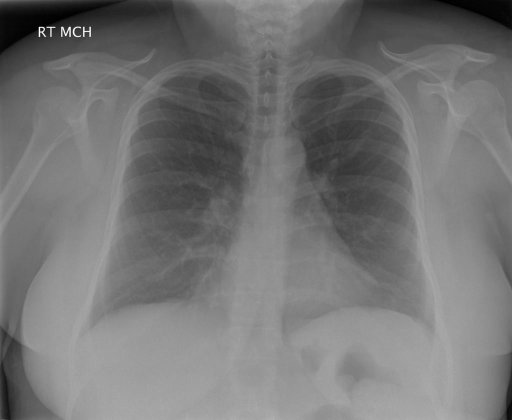

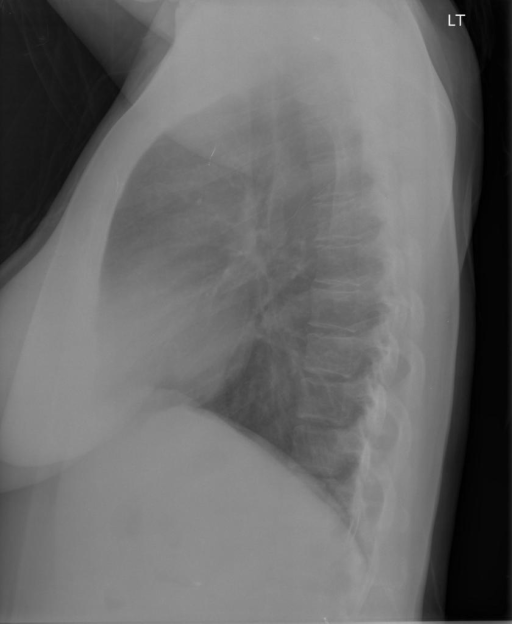

from testing set:


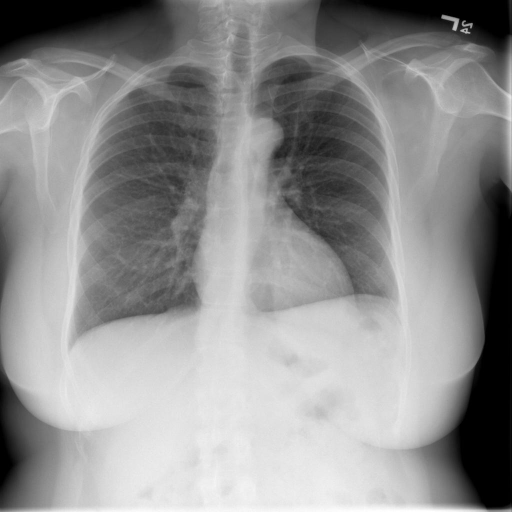

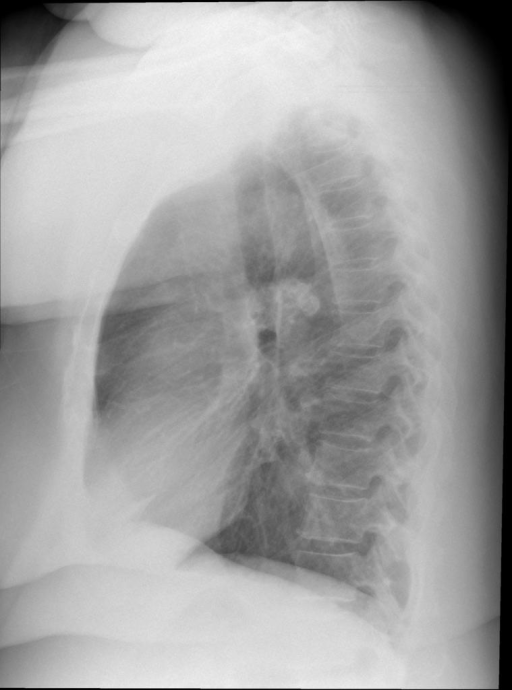

from validation set:


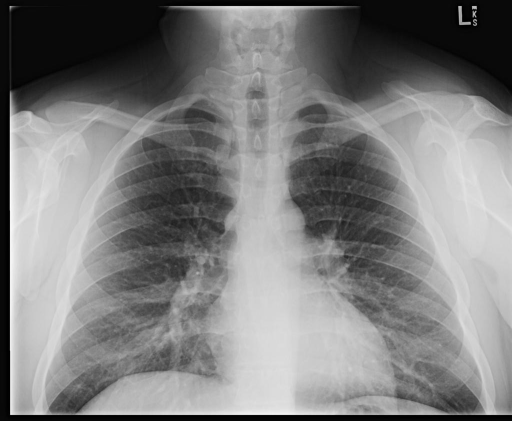

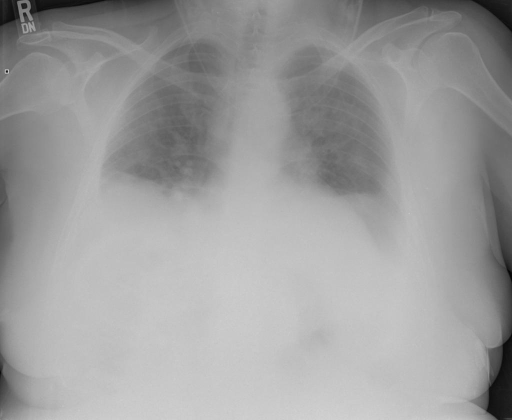

In [16]:
for which in ['micro', 'chest']:
    print(which.upper())
    for set_ in ['training', 'testing', 'validation']:
        print(' '.join(['from', set_, 'set:']))
        for i in range(2):
            rand = random.randint(1, len(micro_valid))
            if set_ == 'validation':
                other = 'other_'
            else:
                other = ''
            path = '{}assets/{}_set/{}/{}_{}.png'.format(other, set_, which, which, rand)
            time.sleep(1)
            display(Image_(path))

Time to classify!